In [1]:
import os
import traceback
import random

import pandas as pd
from certa.explain import CertaExplainer
from certa.local_explain import get_original_prediction, get_row
from certa.utils import merge_sources

from baselines.landmark import Landmark
from baselines.mojito import Mojito
import shap
import dice_ml

import pandas as pd
from certa.explain import CertaExplainer
from models.utils import from_type
import numpy as np

import json
import warnings

import nltk
nltk.download('punkt')

warnings.filterwarnings("ignore")
pd.options.display.max_colwidth = 100

from IPython.display import display
from IPython.display import Image

import graphviz
import pydotplus

[nltk_data] Downloading package punkt to /home/tteofili/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
pred_df = pd.read_csv('predictions.csv')
pred_df.head()

,Unnamed: 0,ltable_Beer_Name,ltable_Brew_Factory_Name,ltable_Style,ltable_ABV,rtable_Beer_Name,rtable_Brew_Factory_Name,rtable_Style,rtable_ABV,nomatch_score,match_score,alteredAttributes,droppedValues,copiedValues,triangle
0,0,Bulleit Bourbon Barrel Aged G'Knight,Oskar Blues Grill & Brew,American Amber / Red Ale,8.70 %,Healthy,Figure Eight Brewing,Barley Wine,-,0.297096,0.702904,"('rtable_Beer_Name',)",['Figure Eight Bourbon Barrel Aged Jumbo Love'],['Healthy'],1@10507 0@1219 1@2470
1,1,Bulleit Bourbon Barrel Aged G'Knight,Oskar Blues Grill & Brew,American Amber / Red Ale,8.70 %,Figure Eight Bourbon Barrel Aged Jumbo Love,Healthy Brew,Barley Wine,-,0.942687,0.057313,"('rtable_Brew_Factory_Name',)",['Figure Eight Brewing'],['Healthy Brew'],1@10507 0@1219 1@2470
2,2,Bulleit Bourbon Barrel Aged G'Knight,Oskar Blues Grill & Brew,American Amber / Red Ale,8.70 %,Figure Eight Bourbon Barrel Aged Jumbo Love,Figure Eight Brewing,Amber Ale,-,0.946805,0.053195,"('rtable_Style',)",['Barley Wine'],['Amber Ale'],1@10507 0@1219 1@2470
3,3,Bulleit Bourbon Barrel Aged G'Knight,Oskar Blues Grill & Brew,American Amber / Red Ale,8.70 %,Figure Eight Bourbon Barrel Aged Jumbo Love,Figure Eight Brewing,Barley Wine,-,0.943421,0.056579,"('rtable_ABV',)",['-'],['-'],1@10507 0@1219 1@2470
4,4,Wave,Oskar Blues Grill & Brew,American Amber / Red Ale,8.70 %,Figure Eight Bourbon Barrel Aged Jumbo Love,Figure Eight Brewing,Barley Wine,-,0.367473,0.632527,"('ltable_Beer_Name',)","[""Bulleit Bourbon Barrel Aged G'Knight""]",['Wave'],0@57766 1@2470 0@1219


In [3]:
gbo = pred_df.groupby('triangle')

In [4]:
triangle_ids = list(gbo.groups.keys())

In [5]:
import seaborn as sns
cm = sns.light_palette("blue", as_cmap=True)

In [6]:
root_datadir = '../cheapER/datasets/'
experiments_dir = 'examples/'
dataset = 'beers'
datadir = os.path.join(root_datadir, dataset)

In [7]:
lsource = pd.read_csv(datadir + '/tableA.csv')
rsource = pd.read_csv(datadir + '/tableB.csv')
gt = pd.read_csv(datadir + '/train.csv')
valid = pd.read_csv(datadir + '/valid.csv')
test = pd.read_csv(datadir + '/test.csv')

test_df = merge_sources(test, 'ltable_', 'rtable_', lsource, rsource, ['label'], [])
valid_df = merge_sources(valid, 'ltable_', 'rtable_', lsource, rsource, ['label'], [])
train_df = merge_sources(gt, 'ltable_', 'rtable_', lsource, rsource, ['label'], ['id'])

In [8]:
model_type = 'dm'
model = from_type(model_type)
save_path = 'models/saved/' + model_type + '/beers'
model.load(save_path)

In [9]:
def predict_fn(x):
    return model.predict(x)
def predict_fn_mojito(x):
    return model.predict(x, mojito=True)

In [10]:
predictions = model.predict(test_df)
predictions

,label,ltable_ABV,ltable_Beer_Name,ltable_Brew_Factory_Name,ltable_Style,ltable_id,rtable_ABV,rtable_Beer_Name,rtable_Brew_Factory_Name,rtable_Style,rtable_id,nomatch_score,match_score
0,0,8.70 %,Bulleit Bourbon Barrel Aged G'Knight,Oskar Blues Grill & Brew,American Amber / Red Ale,1219.0,-,Figure Eight Bourbon Barrel Aged Jumbo Love,Figure Eight Brewing,Barley Wine,2470.0,0.943249,0.056751
1,0,8.20 %,Double Dragon Imperial Red Ale,Phillips Brewing Company,American Amber / Red Ale,492.0,7.10 %,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale,1635.0,0.975957,0.024043
2,1,7.40 %,Honey Basil Amber,Rude Hippo Brewing Company,American Amber / Red Ale,3917.0,7.40 %,Rude Hippo Honey Basil Amber,18th Street Brewery,Amber Ale,2224.0,0.183886,0.816114
3,0,9.70 %,Clifford 's Big Red Ale,Funky Buddha Brewery,American Amber / Red Ale,2155.0,6.50 %,Big Island Red Giant Ale,Big Island Brewhaus,American Strong Ale,2948.0,0.934337,0.065663
4,1,4.50 %,Real McCoy Amber Ale,Mammoth Brewing Company,American Amber / Red Ale,271.0,4.50 %,Mammoth Real McCoy Amber Ale,Mammoth Brewing Company,Altbier,1410.0,0.501621,0.498379
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0,5.40 %,Mountain City Amber Ale,Tommyknocker Brewery,American Amber / Red Ale,2115.0,5.20 %,Colorado Mountain Ole 59er Amber Ale,Colorado Mountain Brewery,Amber Ale,77.0,0.898074,0.101926
87,1,10.00 %,Thomas Hooker Old Marley Barleywine,Thomas Hooker Brewing Company,American Barleywine,4063.0,10 %,Thomas Hooker Old Marley Barleywine,Thomas Hooker Brewing Company,Barley Wine,2331.0,0.423183,0.576817
88,1,-,Centurion Barleywine Ale,Golden City Brewery,American Barleywine,4161.0,11.20 %,Golden City Centurion Barleywine Ale,Golden City Brewery,Barley Wine,2409.0,0.877802,0.122198
89,1,6.00 %,Red Ale Priprioca,Cervejaria AmazÃ ´ nia Ltda .,American Amber / Red Ale,862.0,6 %,Amazon Beer Priprioca Red Ale,Amazon Beer,Amber Ale,2906.0,0.830464,0.169536


In [11]:
false_positives = predictions.loc[(predictions['label'] == 0) & (predictions['match_score'] > 0.5)]
false_negatives = predictions.loc[(predictions['label'] == 1) & (predictions['match_score'] < 0.5)]
true_positives = predictions.loc[(predictions['label'] == 1) & (predictions['match_score'] > 0.5)]
true_negatives = predictions.loc[(predictions['label'] == 0) & (predictions['match_score'] < 0.5)]

In [12]:
certa_explainer = CertaExplainer(lsource, rsource)

In [13]:
i = 1
rand_row =  test_df.iloc[i]
l_id = int(rand_row['ltable_id'])
label = rand_row["label"]
l_tuple = lsource.iloc[l_id]
r_id = int(rand_row['rtable_id'])
r_tuple = rsource.iloc[r_id]
rand_row.head()

label                                                    0
ltable_ABV                                          8.20 %
ltable_Beer_Name            Double Dragon Imperial Red Ale
ltable_Brew_Factory_Name          Phillips Brewing Company
ltable_Style                      American Amber / Red Ale
Name: 1, dtype: object

In [14]:
label = rand_row['label']
label

0

In [15]:
item = get_row(l_tuple, r_tuple)
n_item = item.drop(['ltable_id','rtable_id'],axis=1)
n_item.reindex(sorted(n_item.columns), axis=1)

,ltable_ABV,ltable_Beer_Name,ltable_Brew_Factory_Name,ltable_Style,rtable_ABV,rtable_Beer_Name,rtable_Brew_Factory_Name,rtable_Style
0,8.20 %,Double Dragon Imperial Red Ale,Phillips Brewing Company,American Amber / Red Ale,7.10 %,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale


In [16]:
saliency_df, cf_summary, counterfactual_examples, triangles, lattices = certa_explainer.explain(l_tuple, r_tuple, predict_fn)

In [17]:
saliency_df.reindex(sorted(saliency_df.columns), axis=1).style.background_gradient(cmap=cm, axis=1, low=0.1, high=0.6)

,ltable_ABV,ltable_Beer_Name,ltable_Brew_Factory_Name,ltable_Style,rtable_ABV,rtable_Beer_Name,rtable_Brew_Factory_Name,rtable_Style
0,0.447761,0.656716,0.373134,0.373134,0.320896,0.522388,0.320896,0.402985


In [18]:
counterfactual_examples

,ltable_Beer_Name,ltable_Brew_Factory_Name,ltable_Style,ltable_ABV,rtable_Beer_Name,rtable_Brew_Factory_Name,rtable_Style,rtable_ABV,nomatch_score,match_score,alteredAttributes,droppedValues,copiedValues,triangle,attr_count
29,Mateo Loco,Phillips Brewing Company,American Amber / Red Ale,10.00 %,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale,7.10 %,0.3467586636543274,0.6532413363456726,"('ltable_Beer_Name', 'ltable_ABV')","['Double Dragon Imperial Red Ale', '8.20 %']","['Mateo Loco', '10.00 %']",0@64025 1@1635 0@492,2
36,Mateo Loco,Phillips Brewing Company,American Amber / Red Ale,%,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale,7.10 %,0.31175321340560913,0.6882467865943909,"('ltable_Beer_Name', 'ltable_ABV')","['Double Dragon Imperial Red Ale', '8.20 %']","['Mateo Loco', '%']",0@64031 1@1635 0@492,2
41,House,Phillips Brewing Company,American Amber / Red Ale,5.10 %,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale,7.10 %,0.33189594745635986,0.6681040525436401,"('ltable_Beer_Name', 'ltable_ABV')","['Double Dragon Imperial Red Ale', '8.20 %']","['House', '5.10 %']",0@11685 1@1635 0@492,2
43,Bushwacker,Phillips Brewing Company,American Amber / Red Ale,7.10 %,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale,7.10 %,0.4062122106552124,0.5937877893447876,"('ltable_Beer_Name', 'ltable_ABV')","['Double Dragon Imperial Red Ale', '8.20 %']","['Bushwacker', '7.10 %']",0@23947 1@1635 0@492,2
48,Mateo,Phillips Brewing Company,American Amber / Red Ale,10.00 %,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale,7.10 %,0.24258726835250854,0.7574127316474915,"('ltable_Beer_Name', 'ltable_ABV')","['Double Dragon Imperial Red Ale', '8.20 %']","['Mateo', '10.00 %']",0@64018 1@1635 0@492,2
26,Oktoberfest,Phillips Brewing Company,American Amber / Red Ale,6.10 %,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale,7.10 %,0.40743488073349,0.59256511926651,"('ltable_Beer_Name', 'ltable_ABV')","['Double Dragon Imperial Red Ale', '8.20 %']","['Oktoberfest', '6.10 %']",0@29669 1@1635 0@492,2
16,Shuffle,Phillips Brewing Company,American Amber / Red Ale,5.10 %,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale,7.10 %,0.3127260208129883,0.6872739791870117,"('ltable_Beer_Name', 'ltable_ABV')","['Double Dragon Imperial Red Ale', '8.20 %']","['Shuffle', '5.10 %']",0@68725 1@1635 0@492,2


In [19]:
cf_summary

ltable_Beer_Name/ltable_ABV    0.5
dtype: float64

In [39]:
lattice = lattices[5]
lattice.triangle

,id,Beer_Name,Brew_Factory_Name,Style,ABV,type
1635,1635,Scuttlebutt Mateo Loco Imperial Red Ale,Scuttlebutt Brewing Co. .,American Strong Ale,7.10 %,pivot
492,492,Double Dragon Imperial Red Ale,Phillips Brewing Company,American Amber / Red Ale,8.20 %,free
3055,64021,Mateo Loco,Company,American Amber / Red Ale,10.00 %,support


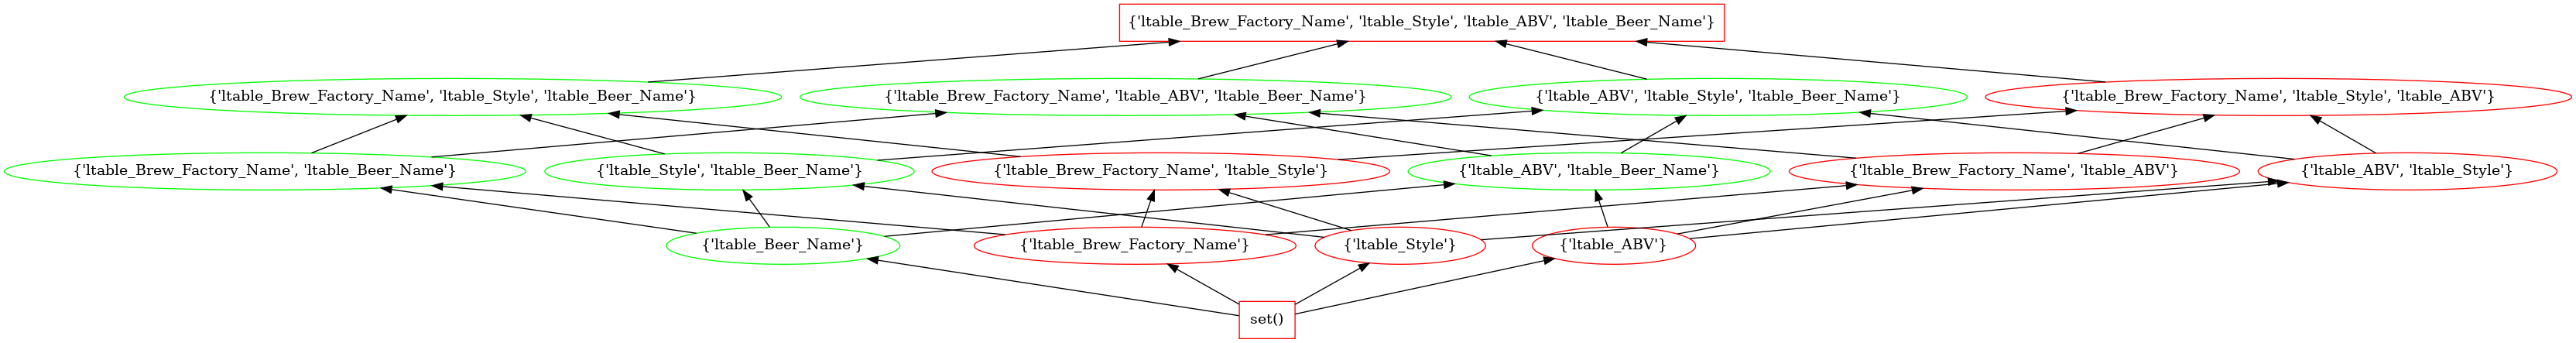

In [40]:


dot_data = lattice.hasse() 
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)

Image(pydot_graph.create_png())